In [1]:
# Imports and environment checks
import os
import sys
import torch
from pathlib import Path
print('Python:', sys.version.split()[0])
print('Torch:', torch.__version__)
print('CUDA available:', torch.cuda.is_available())
if torch.cuda.is_available():
    print('CUDA device:', torch.cuda.get_device_name(0))

# check data dirs
base = Path('..') if Path('..').exists() else Path('.')
data_root = Path('..') / 'data' if (Path('..') / 'data').exists() else Path('data')
print('Data root:', data_root)

Python: 3.10.12
Torch: 2.5.1+cu124
CUDA available: True
CUDA device: NVIDIA GeForce RTX 3070 Ti Laptop GPU
Data root: data


In [2]:
# YOLOv8 training example (ultralytics API)
# This cell only defines the training call. Run with care (GPU required for reasonable speed).
from ultralytics import YOLO

# Choose a small pretrained model for quick experiments
model = YOLO('yolov8n.pt')  # or 'yolov8s.pt'

# Example train call - adjust paths and hyperparameters to your environment
# Replace data='data/data.yaml' with the path to your data.yaml if different
# model.train will create runs/detect/... with checkpoints
train_args = dict(
    data='data/data.yaml',
    epochs=50,
    imgsz=640,
    batch=8,
    device=0 if torch.cuda.is_available() else 'cpu',
    workers=4,
    name='yolov8_experiment',
    pretrained=True,
    save=True
)

print('Training config:', train_args)
model.train(**train_args)

Creating new Ultralytics Settings v0.0.6 file ✅ 
View Ultralytics Settings with 'yolo settings' or at '/home/brendan/.config/Ultralytics/settings.json'
Update Settings with 'yolo settings key=value', i.e. 'yolo settings runs_dir=path/to/dir'. For help see https://docs.ultralytics.com/quickstart/#ultralytics-settings.
Training config: {'data': 'data/data.yaml', 'epochs': 50, 'imgsz': 640, 'batch': 8, 'device': 0, 'workers': 4, 'name': 'yolov8_experiment', 'pretrained': True, 'save': True}
Training config: {'data': 'data/data.yaml', 'epochs': 50, 'imgsz': 640, 'batch': 8, 'device': 0, 'workers': 4, 'name': 'yolov8_experiment', 'pretrained': True, 'save': True}
Ultralytics 8.3.223 🚀 Python-3.10.12 torch-2.5.1+cu124 CUDA:0 (NVIDIA GeForce RTX 3070 Ti Laptop GPU, 8192MiB)
engine/trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=8, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, compile=False, conf=None, copy_paste=0.0, cop

ultralytics.utils.metrics.DetMetrics object with attributes:

ap_class_index: array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11])
box: ultralytics.utils.metrics.Metric object
confusion_matrix: <ultralytics.utils.metrics.ConfusionMatrix object at 0x78303beca0b0>
curves: ['Precision-Recall(B)', 'F1-Confidence(B)', 'Precision-Confidence(B)', 'Recall-Confidence(B)']
curves_results: [[array([          0,    0.001001,    0.002002,    0.003003,    0.004004,    0.005005,    0.006006,    0.007007,    0.008008,    0.009009,     0.01001,    0.011011,    0.012012,    0.013013,    0.014014,    0.015015,    0.016016,    0.017017,    0.018018,    0.019019,     0.02002,    0.021021,    0.022022,    0.023023,
          0.024024,    0.025025,    0.026026,    0.027027,    0.028028,    0.029029,     0.03003,    0.031031,    0.032032,    0.033033,    0.034034,    0.035035,    0.036036,    0.037037,    0.038038,    0.039039,     0.04004,    0.041041,    0.042042,    0.043043,    0.044044,    0.045045,  

Running prediction on: ../data/test/images/catterpillar-16-_jpg.rf.a988be4db6128c455b35af2967fdd5a3.jpg

image 1/1 /home/brendan/comp9517/COMP9517-group-project/dl_pipeline/../data/test/images/catterpillar-16-_jpg.rf.a988be4db6128c455b35af2967fdd5a3.jpg: 640x640 (no detections), 23.1ms
Speed: 3.6ms preprocess, 23.1ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 640)
image 1/1 /home/brendan/comp9517/COMP9517-group-project/dl_pipeline/../data/test/images/catterpillar-16-_jpg.rf.a988be4db6128c455b35af2967fdd5a3.jpg: 640x640 (no detections), 23.1ms
Speed: 3.6ms preprocess, 23.1ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 640)
No detections found.
No detections found.


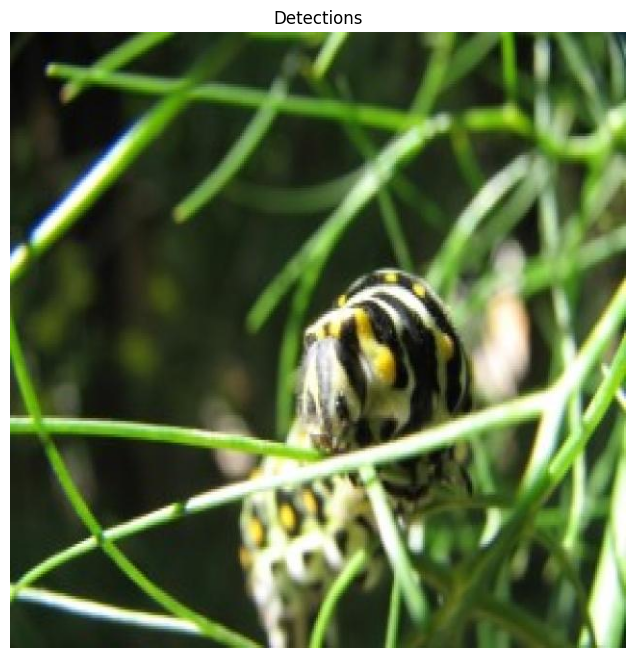

Annotated image saved to: ../results/yolov8_predictions/Caterpillars/annotated_catterpillar-16-_jpg.rf.a988be4db6128c455b35af2967fdd5a3.jpg
Inference summary: total detections = 0


In [15]:
# Inference example with class-name-based random sampling
from ultralytics import YOLO
from IPython.display import display
import pandas as pd
import os
from pathlib import Path
import random
import json

# Load model (weights path or pretrained)
# If you have a trained run, replace with your best weights path
m = YOLO('../runs/detect/yolov8_experiment/weights/best.pt')

# Utility: find a random image containing a given class name
# Strategy: search labels in ../data/test/labels for lines starting with that class id,
# map to image filename, then pick one at random.

def load_class_map(model: YOLO):
    # model.names is a dict like {0: 'ant', 1: 'beetle', ...}
    if hasattr(model, 'names') and isinstance(model.names, (dict, list)):
        if isinstance(model.names, dict):
            return {int(k): v for k, v in model.names.items()}
        else:
            return {i: name for i, name in enumerate(model.names)}
    return {}

CLASS_MAP = load_class_map(m)
INV_CLASS_MAP = {v.lower(): k for k, v in CLASS_MAP.items()}  # name -> id

labels_dir = Path('../data/test/labels')
images_dir = Path('../data/test/images')

# Helper to resolve candidate images for a given class id

def images_for_class(class_id: int):
    candidates = []
    if not labels_dir.exists():
        return candidates
    for lbl in labels_dir.glob('*.txt'):
        try:
            with open(lbl, 'r') as f:
                lines = [ln.strip() for ln in f if ln.strip()]
            # any line with the right class id as first token?
            for ln in lines:
                parts = ln.split()
                if len(parts) >= 1 and parts[0].isdigit() and int(parts[0]) == class_id:
                    # find image file with same stem
                    for ext in ('.jpg', '.jpeg', '.png'):
                        img_path = images_dir / f"{lbl.stem}{ext}"
                        if img_path.exists():
                            candidates.append(img_path)
                            break
                    break  # stop scanning lines for this file once found
        except Exception:
            pass
    return candidates

# User input: provide insect/class name (case-insensitive). If empty, fallback to any test image.
INSECT_NAME = 'Caterpillars'  # e.g., 'Ants', 'Beetles', 'Caterpillars'

if INSECT_NAME:
    cls_id = INV_CLASS_MAP.get(INSECT_NAME.lower())
    if cls_id is None:
        raise ValueError(f"Unknown class name '{INSECT_NAME}'. Known: {sorted(set(CLASS_MAP.values()))}")
    pool = images_for_class(cls_id)
    if not pool:
        raise FileNotFoundError(f"No images found in test set containing class '{INSECT_NAME}'.")
    sample_img = random.choice(pool)
else:
    # Fallback: pick any image from test/images
    image_dir = images_dir
    candidates = []
    for ext in ('.jpg', '.jpeg', '.png'):
        candidates.extend(list(image_dir.glob(f'*{ext}')))
    if not candidates:
        raise FileNotFoundError('No images found in test/images directory.')
    sample_img = random.choice(candidates)

print('Running prediction on:', sample_img)
results = m.predict(source=str(sample_img), save=False, imgsz=640, conf=0.25)

# results is a list; take first item
res = results[0]
boxes = res.boxes  # Boxes object (contains tensor data)

# Extract detection data
if boxes is not None and len(boxes) > 0:
    # xyxy coordinates
    xyxy = boxes.xyxy.cpu().numpy()  # shape (N,4)
    conf = boxes.conf.cpu().numpy()  # shape (N,)
    cls = boxes.cls.cpu().numpy()    # shape (N,)

    # Build a DataFrame for readability
    df = pd.DataFrame(xyxy, columns=['x1','y1','x2','y2'])
    df['confidence'] = conf
    df['class_id'] = cls.astype(int)
    # Map class names
    df['class_name'] = df['class_id'].map(CLASS_MAP)

    # Sort by confidence descending
    df = df.sort_values('confidence', ascending=False).reset_index(drop=True)
    display(df.head(10))
else:
    print('No detections found.')

# Annotated image rendering and save
annotated = res.plot()  # BGR numpy array
import cv2
annotated_rgb = cv2.cvtColor(annotated, cv2.COLOR_BGR2RGB)
import matplotlib.pyplot as plt
plt.figure(figsize=(8,8))
plt.imshow(annotated_rgb)
plt.axis('off')
plt.title('Detections')
plt.show()

# Ensure output dir exists
out_dir = Path(f'../results/yolov8_predictions/{INSECT_NAME}')
out_dir.mkdir(parents=True, exist_ok=True)
out_path = out_dir / f'annotated_{sample_img.name}'
cv2.imwrite(str(out_path), annotated)
print('Annotated image saved to:', out_path)
print('Inference summary: total detections =', 0 if boxes is None else len(boxes))